In [1]:
using BioAlignments
using FASTX
using ProgressMeter
using Printf
using CSV
using Plots
using StatsPlots
using StatsBase
using Distributions
using HypothesisTests
include("source/utils.jl")
include("source/io.jl")
include("source/alignment.jl")
include("source/pctid.jl")
include("source/gumbel.jl");
include("source/mutation.jl")

mutate (generic function with 2 methods)

## Data prep

In [2]:
const BL90 = parse_score_matrix_distribution("data/score-matrix-distributions/out/blosum90.out");
function generate_datasets!(base_sequences; minlength=280, maxlength=320, pctid=0.80)
    filter!(x -> minlength <= length(x) < maxlength, base_sequences)
    rev = reverse.(base_sequences)
    shuf = shufflefast.(base_sequences)
    rev_shuf = reverse.(shuf)
    mut_rev_shuf = mutate(rev_shuf, BL90; pctid=pctid, verbose=true)
    base_sequences, rev, shuf, rev_shuf, mut_rev_shuf
end

generate_datasets! (generic function with 1 method)

In [3]:
sprot,
rev_sprot,
shuf_sprot,
rev_shuf_sprot,
mut_rev_shuf_sprot = generate_datasets!(readsequences("data/sprot.fa"))
writesequences("data/sprot300.fa", sprot)
writesequences("data/rev_sprot300.fa", rev_sprot)
writesequences("data/shuf_sprot300.fa", shuf_sprot)
writesequences("data/rev_shuf_sprot300.fa", rev_shuf_sprot)
writesequences("data/mut_rev_shuf_sprot300.fa", mut_rev_shuf_sprot)

Mutating with model data/score-matrix-distributions/out/blosum90.out 100% Time: 0:00:02


In [4]:
masked_sprot = readsequences("data/masked_sprot.fa")
masked_sprot = replace.(masked_sprot, 'X'=>"")
masked_sprot,
rev_masked_sprot,
shuf_masked_sprot,
rev_shuf_masked_sprot,
mut_rev_shuf_masked_sprot = generate_datasets!(masked_sprot)
writesequences("data/masked_sprot300.fa", masked_sprot)
writesequences("data/rev_masked_sprot300.fa", rev_masked_sprot)
writesequences("data/shuf_masked_sprot300.fa", shuf_masked_sprot)
writesequences("data/rev_shuf_masked_sprot300.fa", rev_shuf_masked_sprot);
writesequences("data/mut_rev_shuf_masked_sprot300.fa", mut_rev_shuf_masked_sprot)

Mutating with model data/score-matrix-distributions/out/blosum90.out 100% Time: 0:00:01


## Align for score

In [5]:
alignmentscore(x1, x2) = align(Pairwise(), x1, x2;
    formatter=x::PairwiseAlignmentResult -> score(x)::Int,
    verbose=true)

alignmentscore (generic function with 1 method)

In [6]:
sprot = readsequences("data/sprot300.fa")
rev_sprot = readsequences("data/rev_sprot300.fa")
shuf_sprot = readsequences("data/shuf_sprot300.fa")
rev_shuf_sprot = readsequences("data/rev_shuf_sprot300.fa")
mut_rev_shuf_sprot = readsequences("data/mut_rev_shuf_sprot300.fa")
masked_sprot = readsequences("data/masked_sprot300.fa")
rev_masked_sprot = readsequences("data/rev_masked_sprot300.fa")
shuf_masked_sprot = readsequences("data/shuf_masked_sprot300.fa")
rev_shuf_masked_sprot = readsequences("data/rev_shuf_masked_sprot300.fa")
mut_rev_shuf_masked_sprot = readsequences("data/mut_rev_shuf_masked_sprot300.fa");

In [9]:
scores_shuf = alignmentscore(shuf_sprot, shufflefast.(shuf_sprot));

Aligning... 100%|████████████████████████████████████████| Time: 0:00:06


In [10]:
scores_rev = alignmentscore(sprot, rev_sprot);

Aligning... 100%|████████████████████████████████████████| Time: 0:00:05


In [11]:
scores_shufrev = alignmentscore(shuf_sprot, rev_shuf_sprot);

Aligning... 100%|████████████████████████████████████████| Time: 0:00:06


In [12]:
scores_maskedshuf = alignmentscore(shuf_masked_sprot, shufflefast.(shuf_masked_sprot));

Aligning... 100%|████████████████████████████████████████| Time: 0:00:06


In [13]:
scores_maskedrev = alignmentscore(masked_sprot, rev_masked_sprot);

Aligning... 100%|████████████████████████████████████████| Time: 0:00:06


In [14]:
scores_maskedshufrev = alignmentscore(shuf_masked_sprot, rev_shuf_masked_sprot);

Aligning... 100%|████████████████████████████████████████| Time: 0:00:07


In [15]:
scores_mutshufrev = alignmentscore(shuf_sprot, mut_rev_shuf_sprot);

Aligning... 100%|████████████████████████████████████████| Time: 0:00:06


In [16]:
scores_maskedmutshufrev = alignmentscore(shuf_masked_sprot, mut_rev_shuf_masked_sprot);

Aligning... 100%|████████████████████████████████████████| Time: 0:00:06


## Fit Gumbel Distributions to Score Data

For general information on Gumbel distributions:

https://en.wikipedia.org/wiki/Gumbel_distribution

For details on the particular type we are constructing:

https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.Gumbel

Because `Distributions.jl` doesn't seem to offer a simple way to fit Gumbel distributions, I made a quick implementation of `fit(Gumbel, data)` by wrapping the codes published in this blog:

https://djalil.chafai.net/blog/2018/02/18/gumbel-fit-with-julia/

In [17]:
S = (
    scores_shuf, scores_rev, scores_shufrev, scores_mutshufrev, 
    scores_maskedshuf, scores_maskedrev, scores_maskedshufrev, scores_maskedmutshufrev,
)
D = (
    gumbel_shuf, gumbel_rev, gumbel_shufrev, gumbel_mutshufrev, 
    gumbel_maskedshuf, gumbel_maskedrev, gumbel_maskedshufrev, gumbel_maskedmutshufrev,
) = fit.(Gumbel, S)
D = permutedims(reshape(collect(D), (4,2)))
L = [
    "Gumbel(SP-SH)" "Gumbel(SP-RV)" "Gumbel(SH-SHRV)" "Gumbel(SH-MTSHRV)"; 
    "Gumbel(SP-SH_masked)" "Gumbel(SP-RV_masked)" "Gumbel(SH-SHRV_masked)" "Gumbel(SH-MTSHRV_masked)"
]
display(hcat(L[1,:],D[1,:]))
display(hcat(L[2,:],D[2,:]))

4×2 Matrix{Any}:
 "Gumbel(SP-SH)"      Gumbel{Float64}(μ=34.1344, θ=5.56566)
 "Gumbel(SP-RV)"      Gumbel{Float64}(μ=46.9649, θ=10.6611)
 "Gumbel(SH-SHRV)"    Gumbel{Float64}(μ=45.167, θ=8.9408)
 "Gumbel(SH-MTSHRV)"  Gumbel{Float64}(μ=39.6907, θ=7.0031)

4×2 Matrix{Any}:
 "Gumbel(SP-SH_masked)"      Gumbel{Float64}(μ=33.6729, θ=4.89562)
 "Gumbel(SP-RV_masked)"      Gumbel{Float64}(μ=45.7125, θ=8.73609)
 "Gumbel(SH-SHRV_masked)"    Gumbel{Float64}(μ=44.4673, θ=8.23796)
 "Gumbel(SH-MTSHRV_masked)"  Gumbel{Float64}(μ=39.2748, θ=6.52313)

## Run Anderson-Darling tests

On measuring the goodness of fit of Gumbel distributions:

https://www.semanticscholar.org/paper/The-Goodness-of-fit-Test-for-Gumbel-Distribution:-A-Abidin-Adam/c57f0845b518ab95717634017edeb40aa25b08f2

On the AD test implemented in `HypothesisTests.jl`:

https://juliastats.org/HypothesisTests.jl/v0.6/nonparametric.html#Anderson-Darling-test-1

In [18]:
#todo

## Kullback-Leibler Divergence of Gumbel Distributions
Implements the KL divergence derived by Manuel Gil in his thesis:

http://www.mast.queensu.ca/~communications/Papers/gil-msc11.pdf 

which I found via a StackExchange post:

https://stats.stackexchange.com/questions/462346/kl-divergence-for-generalized-extreme-value-distribution

In [19]:
#todo

## Plot Score Frequencies with Gumbel PDFs

In [20]:
function display_gumbel_pdf(D::Array{Gumbel{T}}, x::S) where {T,S <: Real}
    println("PDF at score=$x")
    display(pdf.(D, x))
end
display(L)
display_gumbel_pdf(D, 75)
display_gumbel_pdf(D, 100)
display_gumbel_pdf(D, 125)
display_gumbel_pdf(D, 150)

2×4 Matrix{String}:
 "Gumbel(SP-SH)"         …  "Gumbel(SH-MTSHRV)"
 "Gumbel(SP-SH_masked)"     "Gumbel(SH-MTSHRV_masked)"

PDF at score=75


2×4 Matrix{Float64}:
 0.000116256  0.00629267  0.00383762  0.000916662
 4.40486e-5   0.00386833  0.00290982  0.000638597

PDF at score=100


2×4 Matrix{Float64}:
 1.30292e-6  0.000643778  0.000242214  2.5976e-5
 2.66841e-7  0.00022858   0.000143237  1.38855e-5

PDF at score=125


2×4 Matrix{Float64}:
 1.4593e-8   6.20925e-5  1.48157e-5  7.31616e-7
 1.61615e-9  1.3093e-5   6.89569e-6  3.00718e-7

PDF at score=150


2×4 Matrix{Float64}:
 1.63444e-10  5.95509e-6  9.04512e-7  2.06025e-8
 9.78831e-12  7.48636e-7  3.31615e-7  6.51207e-9

In [21]:
function plot_gumbel_pdf!(d::Gumbel, X::Vector, name, color, style)
    Y = pdf.(d, X)
    plot!(X, Y, label=name, color=color, dpi=300, style=style)
end
colors=theme_palette(:auto);

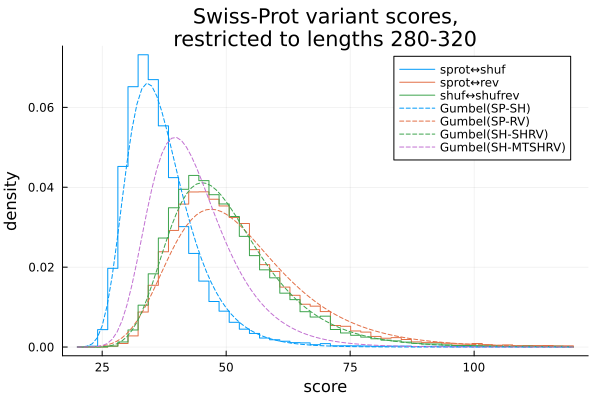

In [22]:
plot(title="Swiss-Prot variant scores,\nrestricted to lengths 280-320",xlabel="score",ylabel="density")
stephist!(scores_shuf, norm=true, bins=range(20,120,50), label="sprot↔shuf", dpi=300)
stephist!(scores_rev, norm=true, bins=range(20,120,50), label="sprot↔rev", dpi=300)
stephist!(scores_shufrev, norm=true, bins=range(20,120,50), label="shuf↔shufrev", dpi=300)
#plot(xlabel="score",ylabel="-pdf")
plot_gumbel_pdf!.(D[1,:], [collect(20:120)], L[1,:], colors[1:4], [:dash])
plot!(dpi=300)
savefig("figures/ScoreRidgelines_sprot")
plot!()

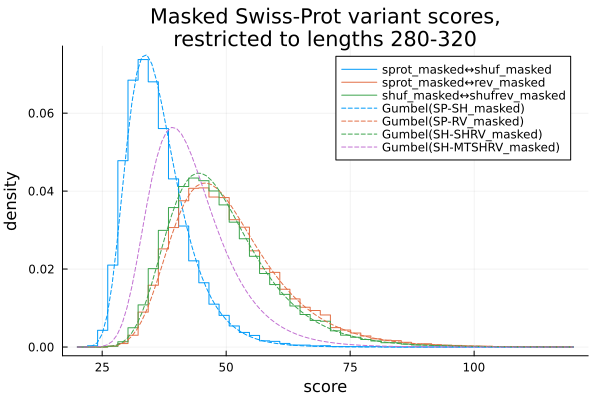

In [23]:
plot(title="Masked Swiss-Prot variant scores,\nrestricted to lengths 280-320",xlabel="score",ylabel="density")
stephist!(scores_maskedshuf, norm=true, bins=range(20,120,50), label="sprot_masked↔shuf_masked", dpi=300)
stephist!(scores_maskedrev, norm=true, bins=range(20,120,50), label="sprot_masked↔rev_masked", dpi=300)
stephist!(scores_maskedshufrev, norm=true, bins=range(20,120,50), label="shuf_masked↔shufrev_masked", dpi=300)
#plot(xlabel="score",ylabel="-pdf")
plot_gumbel_pdf!.(D[2,:], [collect(20:120)], L[2,:], colors[1:4], [:dash])
plot!(dpi=300)
savefig("figures/ScoreRidgelines_masked")
plot!()

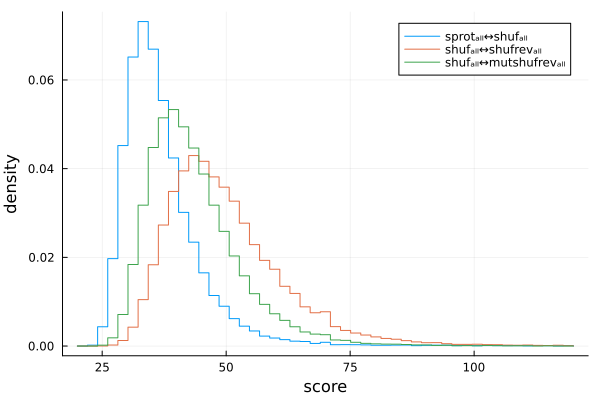

In [27]:
plot(
    #title="Mutated Reversals,\nrestricted to lengths 280-320",
    xlabel="score",ylabel="density")
stephist!(scores_shuf, norm=true, bins=range(20,120,50), label="sprotₐₗₗ↔shufₐₗₗ", dpi=300)
stephist!(scores_shufrev, norm=true, bins=range(20,120,50), label="shufₐₗₗ↔shufrevₐₗₗ", dpi=300)
stephist!(scores_mutshufrev, norm=true, bins=range(20,120,50), label="shufₐₗₗ↔mutshufrevₐₗₗ", dpi=300)
plot!(dpi=600)
savefig("figures/ScoreRidgelines_sprot")
plot!()

## Log PDF Plots 

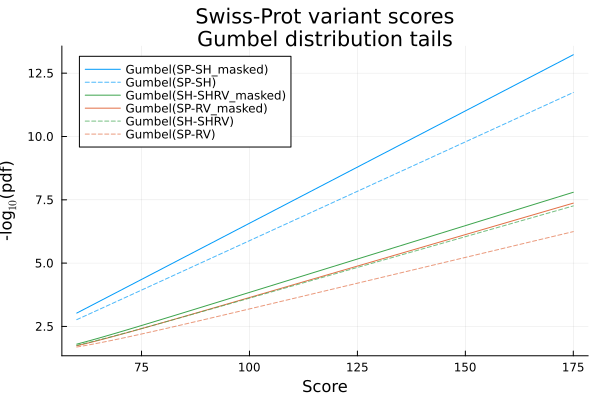

In [25]:
function plot_gumbel_logpdf!(d::Gumbel, X::Vector, name, color; style=:auto, alpha=1)
    Y = -log.(10, pdf.(d, X))
    plot!(X, Y, label=name, linestyle=style, color=color, alpha=alpha, dpi=300)
end
plot(title="Swiss-Prot variant scores\nGumbel distribution tails", xlabel="Score",ylabel="-log\$_{10}\$(pdf)")
X = collect(60:175)
plot_gumbel_logpdf!(D[2,1], X, L[2,1], colors[1]; style=:solid)
plot_gumbel_logpdf!(D[1,1], X, L[1,1], colors[1]; style=:dash, alpha=0.7)
plot_gumbel_logpdf!(D[2,3], X, L[2,3], colors[3]; style=:solid)
plot_gumbel_logpdf!(D[2,2], X, L[2,2], colors[2]; style=:solid)
plot_gumbel_logpdf!(D[1,3], X, L[1,3], colors[3]; style=:dash, alpha=0.7)
plot_gumbel_logpdf!(D[1,2], X, L[1,2], colors[2]; style=:dash, alpha=0.7)
plot!(dpi=300)
savefig("figures/ScoreRidgelines_gumbeltails")
plot!()